In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import matplotlib.gridspec as gridspec
import numpy as np
import networkx as nx
import seaborn as sns

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

from classes.agent import Agent
from classes.world import World
from classes.color_maps import ColorMaps
from classes.utils import *
from classes.news import News
from classes.agent import AgentState

In [8]:
def activate_agents(agents):
    for agent in agents.keys():
        agent.states[agents[agent]] = AgentState.ACTIVE

def news_cascade(agents, news):
    return sum([1 if a.states[news] == AgentState.ACTIVE else 0 for a in agents])
    
def find_degreecentral_nodes(world, k, blacklist):
    degree_centrality = []
    for _ in range(k):
        best = None
        bdeg = -1
        for a in world.graph.nodes():
            if world.agents[a] in degree_centrality or world.agents[a] in blacklist:
                continue
            d = world.graph.out_degree(a)
            if d > bdeg:
                bdeg = d
                best = world.agents[a]
        degree_centrality.append(best)
    return degree_centrality
        
def full_dynamics(w, starting_points, n_iter=20):
    for d in starting_points.values():
        for agent in d.keys():
            agent.independence = 1.0 
    t = 0
    while t < n_iter:
        if t in starting_points.keys():
            activate_agents(starting_points[t])
        w.update(verbose=True)
        t += 1
    return (news_cascade(w.agents.values(), 0), news_cascade(w.agents.values(), 1))
            

In [9]:
def get_value(sensation, size1, size2, n=1000, samples=10):
    #threshold = np.clip(np.random.normal(0.5, 0.1, n), 0.0, 1.0) #mu = 0.5, sigma = 0.1
    #independence = np.clip(np.random.normal(0.5, 0.1, n), 0.0, 1.0) #mu = 0.5, sigma = 0.1
    threshold = np.random.random(n)
    independence = np.random.random(n) * 0.01
    names_agents = [_ for _ in range(n)]
    e = 0.0
    for sample in range(samples):
        news1 = News(0, sensation, 0.0) #swap order of news for half of the samples as the starting nodes slightly prioritize news 1
        news2 = News(1, sensation, 0.0)
        news_cycle = {news1.name: news1, news2.name: news2}
        w = construct_world(names_agents, threshold, independence, news_cycle)
        spreader = find_degreecentral_nodes(w, size1 + size2, [])
        s = {}
        i1 = 0
        i2 = 0
        for agent in spreader: #attribute agents to news 5 to first news rest to second
            if i1 < size1:
                s[agent] = news1.name
                i1 += 1
            elif i2 < size2:
                s[agent] = news2.name
                i2 += 1
        starting_points = {0: s}
        c1, c2 = full_dynamics(w, starting_points)
        e += c1 - c2
    return e / samples

In [10]:
def calc_sensation_vs_sensation_vs_size1_vs_size2(sensations, sizes1, sizes2, n=50):
    slen = len(sensations)
    s1len = len(sizes1)
    s2len = len(sizes2)
    r = np.zeros((slen, s1len, s2len))
    for s in range(slen):
        for i in range(s1len):
            for j in range(s2len):
                r[s, i, j] = get_value(sensations[s], sizes1[i], sizes2[j], n=n)
        print("=", end="", flush=True)
    print(" done")
    return r

In [11]:
sensations = np.linspace(0.1, 0.9, 10)
sizes = [x for x in range(1, 10, 2)]
n = 1000
r = calc_sensation_vs_size1_vs_size2(sensations, sizes, n=n) #will take some time
r = r / np.float32(n)

====== done


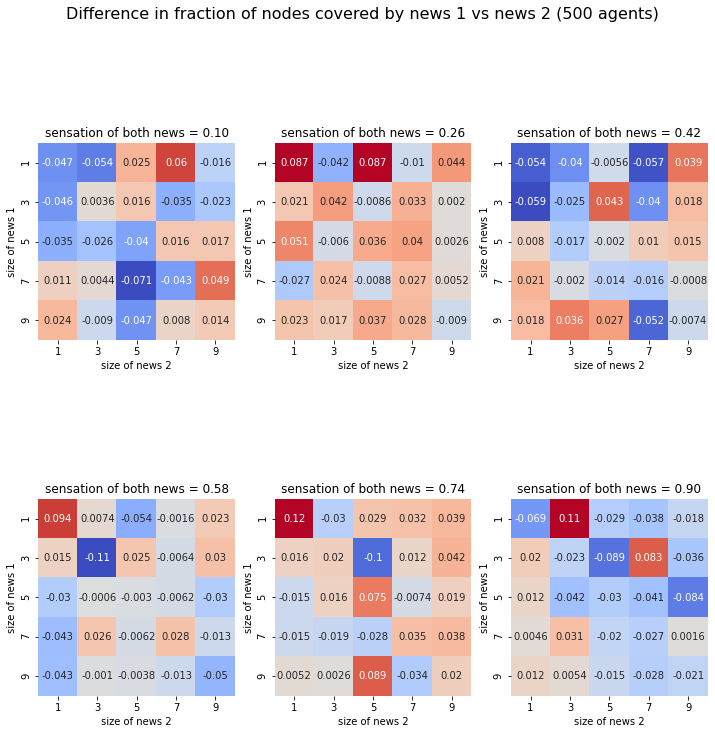

In [12]:
f = plt.figure(figsize=(12,12))
f.suptitle("Difference in fraction of nodes covered by news 1 vs news 2 ({:d} agents)".format(n), fontsize=16)
for i in range(2):
    for j in range(3):
        d = 3*i + j
        if d >= len(sensations): break
        ax = f.add_subplot(2, 3, d+1)
        ax = sns.heatmap(r[d], center=0.0, 
                         annot=True,
                         cmap="coolwarm", cbar=True,
                         xticklabels=sizes, yticklabels=sizes,
                         square = True)
        ax.set_ylabel("initial size of news 1")
        ax.set_xlabel("initial size of news 2")
        ax.set_title("sensation of both news = {:.2f}".format(sensations[d]))
